In [32]:
import pandas as pd
import seaborn as sns

In [33]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import RobustScaler

In [34]:
# seaborn 한글 안깨지게
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='white')

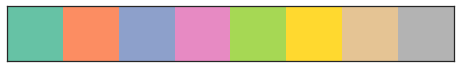

In [35]:
# seaborn palette -> 찾아보고 마음에 드는걸로 바꿔도 괜찮 !
palette = sns.color_palette('Set2') # palette 이름 () 안에 넣어주고
sns.palplot(palette) # 색상 확인
sns.set_palette('Set2') # 기본 palette로 적용됨

In [36]:
child=pd.read_csv("어린이인구.csv",encoding="cp949")

In [37]:
child=child[["행정동","어린이수"]]
child

,행정동,어린이수
0,가락1동,2054
1,가락2동,1819
2,가락본동,1045
3,가리봉동,167
4,가산동,423
...,...,...
419,효창동,498
420,후암동,653
421,휘경1동,518
422,휘경2동,879


## 어린이수-사고수

In [38]:
# 데이터 불러오기
child_traffic=pd.read_csv("어린이환산교통사고.csv",encoding="cp949")

In [39]:
# 중복 확인
child_traffic[child_traffic.duplicated(['행정동'])==True]

,행정동,환산건


In [40]:
child_acc=pd.merge(child,child_traffic,on="행정동")
child_acc

,행정동,어린이수,환산건
0,가락1동,2054,1.119
1,가락2동,1819,0.387
2,가락본동,1045,0.494
3,가리봉동,167,0.000
4,가산동,423,0.000
...,...,...,...
419,효창동,498,0.000
420,후암동,653,0.210
421,휘경1동,518,0.000
422,휘경2동,879,0.000


In [41]:
# 사고수 0인 행정동 제거 (df_acc)
df_acc = child_acc.drop(index = child_acc[child_acc['환산건']==0].index)
df_acc=df_acc.reset_index(drop=True)
df_acc

,행정동,어린이수,환산건
0,가락1동,2054,1.119
1,가락2동,1819,0.387
2,가락본동,1045,0.494
3,개봉1동,1382,0.400
4,개봉2동,1426,0.465
...,...,...,...
193,화곡6동,849,0.179
194,화곡8동,856,0.290
195,화곡본동,1384,0.252
196,화양동,254,0.560


In [42]:
# scaling
scaler = RobustScaler()
df_acc_scale=pd.DataFrame(scaler.fit_transform(df_acc[['어린이수','환산건']]),columns=df_acc[['어린이수','환산건']].columns)
df_acc_scale.insert(0, '행정동', df_acc['행정동'])
df_acc_scale

,행정동,어린이수,환산건
0,가락1동,1.430303,1.853376
1,가락2동,1.113805,-0.029582
2,가락본동,0.071380,0.245659
3,개봉1동,0.525253,0.003859
4,개봉2동,0.584512,0.171061
...,...,...,...
193,화곡6동,-0.192593,-0.564630
194,화곡8동,-0.183165,-0.279100
195,화곡본동,0.527946,-0.376849
196,화양동,-0.993939,0.415434


C:\Users\gtsye\anaconda3\envs\dongguk\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "


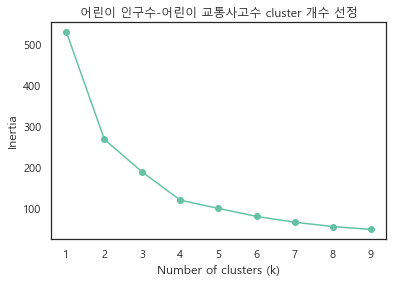

In [43]:
# elbow
data=df_acc_scale.values
X=data[:,1:]

num_clusters = list(range(1,10))
inertias = []

for i in num_clusters:
    model = KMeans(n_clusters=i)
    model.fit(X)
    inertias.append(model.inertia_)

plt.title('어린이 인구수-어린이 교통사고수 cluster 개수 선정')
plt.plot(num_clusters, inertias, '-o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()

k = 4

Text(0.5, 1.0, '어린이 인구수와 어린이 교통사고 clustering')

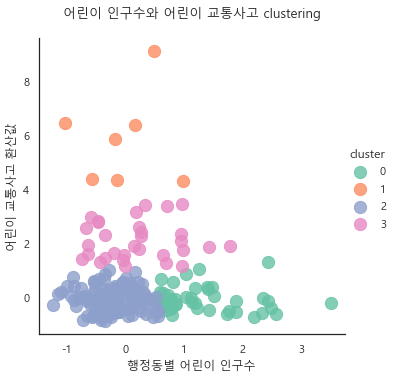

In [44]:
# clustering
kmeans = KMeans(n_clusters=4).fit(X)
kmeans.cluster_centers_
kmeans.labels_
df_acc_scale['cluster'] = kmeans.labels_

sns.lmplot(x='어린이수',y='환산건', data = df_acc_scale, fit_reg=False, scatter_kws={"s":150},hue="cluster")
plt.xlabel('행정동별 어린이 인구수')
plt.ylabel('어린이 교통사고 환산값')
plt.title('어린이 인구수와 어린이 교통사고 clustering', fontsize = 13, pad = 20) # pad : 제목과 그림 사이 간격

cluster 1(상단) 선정

In [45]:
df_acc['cluster'] = df_acc_scale['cluster']
df_acc[df_acc['cluster']==1]

,행정동,어린이수,환산건,cluster
11,고척1동,859,2.668,1
21,남가좌1동,1350,3.935,1
22,남가좌2동,1723,2.065,1
41,미아동,573,2.100,1
117,신대방1동,1114,2.874,1
120,신림동,234,2.900,1
188,홍은2동,891,2.078,1


해당 cluster에 어린이가 너무 적다는 문제 발견 <br>
scaling 된 어린이 값 > 0 을 이용해보기로 생각

In [46]:
df_acc_scale_0 = df_acc_scale[df_acc_scale['어린이수']>0]
df_acc_scale_0

,행정동,어린이수,환산건,cluster
0,가락1동,1.430303,1.853376,3
1,가락2동,1.113805,-0.029582,0
2,가락본동,0.071380,0.245659,2
3,개봉1동,0.525253,0.003859,2
4,개봉2동,0.584512,0.171061,0
...,...,...,...,...
180,창5동,0.039057,0.070740,2
182,천호2동,0.216835,0.111897,2
185,하계2동,0.235690,2.591640,3
189,화곡1동,0.783838,-0.423151,0


C:\Users\gtsye\anaconda3\envs\dongguk\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "


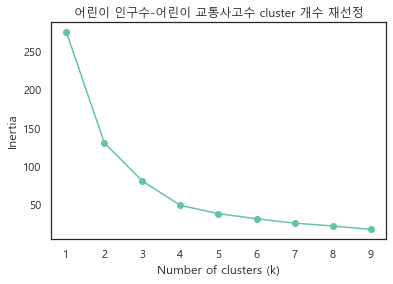

In [47]:
# elbow
data = df_acc_scale_0.values
X=data[:,1:-1]

num_clusters = list(range(1,10))
inertias = []

for i in num_clusters:
    model = KMeans(n_clusters=i)
    model.fit(X)
    inertias.append(model.inertia_)

plt.title('어린이 인구수-어린이 교통사고수 cluster 개수 재선정')
plt.plot(num_clusters, inertias, '-o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()

k = 4

C:\Users\gtsye\anaconda3\envs\dongguk\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


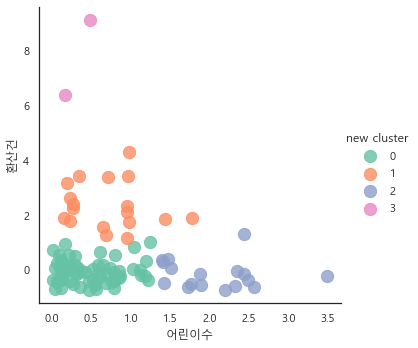

In [48]:
# clustering
kmeans = KMeans(n_clusters=4).fit(X)
kmeans.cluster_centers_
kmeans.labels_
df_acc_scale_0['new cluster'] = kmeans.labels_

sns.lmplot(x='어린이수',y='환산건', data = df_acc_scale_0, fit_reg=False, scatter_kws={"s":150},hue="new cluster")

cluster 1,3 선정

In [49]:
result = df_acc_scale_0[(df_acc_scale_0['new cluster'] == 1)|(df_acc_scale_0['new cluster'] == 3)]
result

,행정동,어린이수,환산건,cluster,new cluster
0,가락1동,1.430303,1.853376,3,1
10,고덕2동,0.956229,1.158842,3,1
12,고척2동,0.272054,2.401286,3,1
13,구로1동,0.342088,3.396785,3,1
18,길동,0.952189,2.318971,3,1
21,남가좌1동,0.482155,9.097106,1,3
22,남가좌2동,0.984512,4.286817,1,1
25,답십리1동,0.971044,3.427653,3,1
26,답십리2동,0.266667,2.239228,3,1
28,대치2동,1.773737,1.871383,3,1


In [50]:
result.to_csv("어린이인구수_어린이교통사고수_clustering.csv",encoding="cp949")